In [1]:
import torch
from torch.nn.functional import one_hot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import gc
from tqdm import tqdm

import sys
from msa_model.modules import MSAContactModel
from msa_model.dataset import MSA, prepare_additional_molecule_feats, aa2tok_d, prepare_msa_masks
from msa_model.utils import fit_seq_weight_mixture_model, evaluate_contact_prediction

from compute_fitness_utils import *


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('high')
print(f"Using device: {torch.cuda.get_device_name(device)}")

sys.path.append("../utils/")
from scoring_utils import get_optimal_window, set_mutant_offset, undo_mutant_offset
from data_utils import DMS_file_cleanup
from msa_utils import MSA_processing

Using device: NVIDIA GH200 480GB


In [2]:
# Parse command line arguments
class args_obj():
    def __init__(self):
        self.model_path = "/home/ubuntu/AF_inv_covariance/model_checkpoints/train_presoftmax_diff_attn_04102025_fullft_no_adversarial/model_step_18000.pt"
        self.contact_model_path = "/home/ubuntu/AF_inv_covariance/model_checkpoints/train_contact_presoftmax_diff_attn_04142025/model_final.pt"
        self.sequence = None
        self.dms_input = "/home/ubuntu/AF_inv_covariance/misc_data/proteingym/DMS_ProteinGym_substitutions/" # A0A140D2T1_ZIKV_Sourisseau_2019.csv"
        self.dms_index = 0
        self.dms_mapping = "/home/ubuntu/ProteinGym/reference_files/DMS_substitutions.csv"
        self.mutation_col = "mutant"
        self.dms_output = "test.csv"
        self.offset_idx = 1
        self.scoring_strategy = "masked-marginals"
        self.msa_path = "/home/ubuntu/AF_inv_covariance/misc_data/proteingym/DMS_msa_files/"
        self.msa_sampling_strategy = "sequence-reweighting"
        self.msa_samples = 400
        self.msa_weights_folder = "msa_weights/" #"/home/ubuntu/AF_inv_covariance/misc_data/proteingym/DMS_msa_weights/"
        self.filter_msa = False
        self.scoring_window = "optimal"
        self.overwrite_prior_scores = True
        self.hhfilter_min_cov = 75
        self.hhfilter_max_seq_id = 90
        self.hhfilter_min_seq_id = 0
        self.path_to_hhfilter = "/home/ubuntu/tools/hhfilter/bin/hhfilter"
        self.seeds = [0]

args = args_obj()

# Load deep mutational scan
mutant_col = args.mutation_col  # Default "mutant"
# If index of DMS file is provided
if args.dms_index is not None:
    mapping_protein_seq_DMS = pd.read_csv(args.dms_mapping)
    DMS_id = mapping_protein_seq_DMS["DMS_id"][args.dms_index]
    print("Compute scores for DMS: "+str(DMS_id))
    row = mapping_protein_seq_DMS[mapping_protein_seq_DMS["DMS_id"]==DMS_id]
    if len(row) == 0:
        raise ValueError("No mappings found for DMS: "+str(DMS_id))
    elif len(row) > 1:
        raise ValueError("Multiple mappings found for DMS: "+str(DMS_id))
    
    row = row.iloc[0]
    row = row.replace(np.nan, "")  # Makes it more manageable to use in strings

    args.sequence = row["target_seq"].upper()
    args.dms_input = str(args.dms_input)+os.sep+row["DMS_filename"]

    mutant_col = row["DMS_mutant_column"] if "DMS_mutant_column" in mapping_protein_seq_DMS.columns else mutant_col
    args.dms_output=str(args.dms_output)+os.sep+DMS_id+'.csv'
    
    target_seq_start_index = row["start_idx"] if "start_idx" in mapping_protein_seq_DMS.columns and row["start_idx"]!="" else 1
    target_seq_end_index = target_seq_start_index + len(args.sequence) 

    # Get MSA file paths and indices
    msa_filename = row["MSA_filename"]
    if msa_filename == "":
        raise ValueError("No MSA found for DMS: "+str(DMS_id))

    args.msa_path= str(args.msa_path)+os.sep+msa_filename # msa_path is expected to be the path to the directory where MSAs are located.
        
    msa_start_index = int(row["MSA_start"]) if "MSA_start" in mapping_protein_seq_DMS.columns else 1
    msa_end_index = int(row["MSA_end"]) if "MSA_end" in mapping_protein_seq_DMS.columns else len(args.sequence)
    
    MSA_weight_file_name = args.msa_weights_folder + os.sep + row["weight_file_name"] if ("weight_file_name" in mapping_protein_seq_DMS.columns and args.msa_weights_folder is not None) else None
    if ((target_seq_start_index!=msa_start_index) or (target_seq_end_index!=msa_end_index)):
        args.sequence = args.sequence[msa_start_index-1:msa_end_index]
        target_seq_start_index = msa_start_index
        target_seq_end_index = msa_end_index
    df = pd.read_csv(args.dms_input)
# If no index of DMS file is provided
else:
    DMS_id = str(args.dms_input).split(os.sep)[-1].split('.csv')[0]
    args.dms_output=str(args.dms_output)+os.sep+DMS_id+'.csv'
    target_seq_start_index = args.offset_idx
    args.sequence = args.target_seq.upper()
    if (args.MSA_start is None) or (args.MSA_end is None): 
        if args.msa_path: print("MSA start and end not provided -- Assuming the MSA is covering the full WT sequence")
        args.MSA_start = 1
        args.MSA_end = len(args.target_seq)
    msa_start_index = args.MSA_start
    msa_end_index = args.MSA_end
    MSA_weight_file_name = args.msa_weights_folder + os.sep + args.weight_file_name if args.msa_weights_folder is not None else None
    df = pd.read_csv(args.dms_input)
# Check if the dataframe is empty
if len(df) == 0:
    raise ValueError("No rows found in the dataframe")
print(f"df shape: {df.shape}", flush=True)

# Load MSA model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_kwargs = dict(
    dim_msa_input = 28,
    dim_pairwise = 256,
    dim_msa = 464,
    dim_logits = 26,
    msa_module_kwargs = dict(
        depth = 22,
        opm_kwargs = dict(
            dim_opm_hidden = 16,
            outer_product_flavor = "presoftmax_differential_attention",
            seq_attn = True,
            dim_qk = 128,
            chunk_size = None,
            return_seq_weights = True,
            return_attn_logits = False,
            lambda_init = None,
            eps = 1e-32,
        ),
        pwa_kwargs = dict(
            heads = 8,
            dim_head = 32,
            dropout = 0.1,
            dropout_type = "row",
        ),
        pairwise_block_kwargs = dict(
            tri_mult_dim_hidden = None,
            use_triangle_attn = False,
            use_triangle_updates = True
        )
    ),
    relative_position_encoding_kwargs = dict(
        r_max = 32,
        s_max = 2,
    ),
    return_msa_repr = False,
    return_pairwise_repr = True,
    query_only = True
)
checkpoint_path = args.model_path
model = MSAContactModel(pretrained_weights_path=checkpoint_path, pretrained_is_final=False, msa_model_kwargs=model_kwargs, compiled_checkpoint=True, dim_contact_hidden=128)

# Load contact model weights
contact_checkpoint_path = args.contact_model_path
contact_checkpoint = torch.load(contact_checkpoint_path, weights_only=True)
contact_state_dict = {k.replace("_orig_mod.", ""): v for k, v in contact_checkpoint.items() if "contact" in k}
_, _ = model.load_state_dict(contact_state_dict, strict=False)
model = model.to(device)
model = model.eval()

# Compute fitness scores
print("Computing model scores...")
args.offset_idx = msa_start_index
# Process MSA
processed_msa = process_msa(filename=args.msa_path, weight_filename=MSA_weight_file_name, filter_msa=args.filter_msa, hhfilter_min_cov=args.hhfilter_min_cov, hhfilter_max_seq_id=args.hhfilter_max_seq_id, hhfilter_min_seq_id=args.hhfilter_min_seq_id, path_to_hhfilter=args.path_to_hhfilter)
if os.path.exists(args.dms_output):
    prior_score_df = pd.read_csv(args.dms_output)
    if not args.overwrite_prior_scores:
        print("Prior scores found -- skipping model scoring")
        exit()
    else:
        print("Overwriting prior scores")
else:
    prior_score_df = None
seed = args.seeds[0]
data = [sample_msa(sampling_strategy=args.msa_sampling_strategy, filename=args.msa_path, nseq=args.msa_samples, weight_filename=MSA_weight_file_name, processed_msa=processed_msa, random_seed=seed)]
assert (args.scoring_strategy in ["masked-marginals","pseudo-ppl"]), "Zero-shot scoring strategy not supported with MSA Transformer"

# Prepare data for MSA model
nTokenTypes = len(np.unique(list(aa2tok_d.values())))
msa_onehot_t, tokenized_msa_t, mask, msa_mask, full_mask, pairwise_mask, additional_feats_t = prepare_msa_inputs(data)
mask, msa_mask, full_mask, pairwise_mask, additional_feats_t = mask.to(device), msa_mask.to(device), full_mask.to(device), pairwise_mask.to(device), additional_feats_t.to(device)

# Compute masked-marginals scores
if args.scoring_strategy == "masked-marginals":
    all_token_probs = []
    for i in tqdm(range(tokenized_msa_t.size(1)), desc="Scoring masked-marginals"):
        tokenized_msa_masked_t = tokenized_msa_t.clone()
        tokenized_msa_masked_t[0, i] = aa2tok_d['MASK']  # mask out first sequence
        if tokenized_msa_t.size(-1) > 1024:
            large_tokenized_msa_masked_t=tokenized_msa_masked_t.clone()
            start, end = get_optimal_window(mutation_position_relative=i, seq_len_wo_special=len(args.sequence)+2, model_window=1024)
            print("Start index {} - end index {}".format(start,end))
            tokenized_msa_masked_t = large_tokenized_msa_masked_t[:,:,start:end]
        else:
            start=0
        with torch.no_grad():
            msa_masked_onehot_t = one_hot(tokenized_msa_masked_t, num_classes=nTokenTypes).float().unsqueeze(0).to(device)
            # token_probs = torch.log_softmax(
            #     model(tokenized_msa_masked_t.cuda())["logits"], dim=-1
            # )
            token_probs = torch.log_softmax(
                model(
                    additional_molecule_feats = additional_feats_t,
                    msa = msa_masked_onehot_t,
                    mask = mask,
                    msa_mask = msa_mask,
                    pairwise_mask = pairwise_mask,
                    full_mask = full_mask
                )['logits'], dim=-1
            )
        all_token_probs.append(token_probs[:, 0, i-start].detach().cpu())  # vocab size
    token_probs = torch.cat(all_token_probs, dim=0).unsqueeze(0)
    df[f"MSA_model"] = df.apply(
        lambda row: label_row(
            row[mutant_col], args.sequence, token_probs.detach().cpu(), aa2tok_d, args.offset_idx
        ),
        axis=1,
    )

Compute scores for DMS: A0A140D2T1_ZIKV_Sourisseau_2019
df shape: (9576, 4)
Layer 0 lambda init: 0.2001953125
Layer 1 lambda init: 0.35546875
Layer 2 lambda init: 0.470703125
Layer 3 lambda init: 0.5546875
Layer 4 lambda init: 0.62109375
Layer 5 lambda init: 0.66796875
Layer 6 lambda init: 0.69921875
Layer 7 lambda init: 0.7265625
Layer 8 lambda init: 0.74609375
Layer 9 lambda init: 0.7578125
Layer 10 lambda init: 0.76953125
Layer 11 lambda init: 0.77734375
Layer 12 lambda init: 0.78515625
Layer 13 lambda init: 0.7890625
Layer 14 lambda init: 0.7890625
Layer 15 lambda init: 0.79296875
Layer 16 lambda init: 0.796875
Layer 17 lambda init: 0.796875
Layer 18 lambda init: 0.796875
Layer 19 lambda init: 0.796875
Layer 20 lambda init: 0.796875
Layer 21 lambda init: 0.80078125
Missing keys:  ['0.weight' '1.weight']
Unexpected keys:  []
Computing model scores...
Number of sequences in MSA (before preprocessing): 16501
Calculating proportion of gaps
Proportion of sequences dropped due to fractio

Scoring masked-marginals: 100%|██████████| 524/524 [10:13<00:00,  1.17s/it]


In [4]:
# 1024 sequences in MSA
# Slightly worse than 400 sequences 45.8 vs 46.4
from scipy.stats import spearmanr
spearmanr(df['DMS_score'], df['MSA_model'])

SpearmanrResult(correlation=0.45767127997347723, pvalue=0.0)

In [4]:
def label_row(row, sequence, token_probs, aa2tok_d, offset_idx):
    score=0
    for mutation in row.split(":"):
        wt, idx, mt = mutation[0], int(mutation[1:-1]) - offset_idx, mutation[-1]
        assert sequence[idx] == wt, "The listed wildtype does not match the provided sequence"

        wt_encoded, mt_encoded = aa2tok_d[wt], aa2tok_d[mt]

        # add 1 for BOS
        score += (token_probs[0, 1 + idx, mt_encoded] - token_probs[0, 1 + idx, wt_encoded]).item()
    return score

SpearmanrResult(correlation=0.46444715004089365, pvalue=0.0)

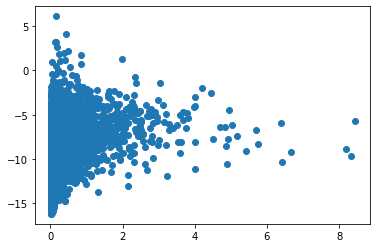

In [46]:
plt.scatter(df['DMS_score'], df['MSA_model'])
spearmanr(df['DMS_score'], df['MSA_model'])

In [43]:
def label_row(row, sequence, token_probs, aa2tok_d, offset_idx):
    score=0
    for mutation in row.split(":"):
        wt, idx, mt = mutation[0], int(mutation[1:-1]) - offset_idx, mutation[-1]
        assert sequence[idx] == wt, "The listed wildtype does not match the provided sequence"

        wt_encoded, mt_encoded = aa2tok_d[wt], aa2tok_d[mt]

        score += (token_probs[0, idx, mt_encoded] - token_probs[0, idx, wt_encoded]).item()
    return score